In [1]:
!pip install evaluate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 3.4 MB/s eta 0:00:00



# Classificador de coredes de cartas do Magic the GatheringE

#### aluno: RAFAEL MAGNO FREITAS NUNES

Este projeto tem como objetivo explorar a aplicação de técnicas de Processamento de Linguagem Natural (PLN) na tarefa de classificação de cartas do  Magic The Gathering, com foco na identificação do cord (Azul, Vermelho, Verde, Branco e Pretos).


### 1 - Data Collection


In [2]:
import requests
import csv

API_URL = "https://api.magicthegathering.io/v1/cards"
OUTPUT_FILE = "mtg_cards_ptbr.csv"
PAGE_SIZE = 100  # máximo permitido


In [3]:
def extract_valid_card_data(card, multilabel: bool = False):
    colors = card.get("colors", [])

    # Multilabel: aceita listas com pelo menos 1 cor
    # TODO (s4lo): implement multilabel classification if time allow
    if multilabel:
        if not isinstance(colors, list) or len(colors) == 0:
            return None
    else:
        if not isinstance(colors, list) or len(colors) != 1:
            return None

    foreign_names = card.get("foreignNames", [])
    for entry in foreign_names:
        if entry.get("language") == "Portuguese (Brazil)":
            required_fields = ["language", "text", "flavor", "name"]
            if all(entry.get(k) and str(entry[k]).strip() for k in required_fields):
                return {
                    "colors": ','.join(colors),
                    "language": entry["language"],
                    "type": entry["type"],
                    "text": entry["text"],
                    "flavor": entry["flavor"],
                    "title": entry["name"]
                }
    return None

def collect_cards(max_pages=None):
    collected_data = []
    page = 1
    while True:
        if max_pages is not None and page > max_pages:
            print("page limit.")
            break
        response = requests.get(API_URL, params={"page": page, "pageSize": PAGE_SIZE})
        if response.status_code != 200:
            print(f"error page {page}: {response.status_code}")
            break
        cards = response.json().get("cards", [])
        if not cards:
            break  # fim dos dados
        for card in cards:
            data = extract_valid_card_data(card)
            if data:
                collected_data.append(data)
        print(f"{page},", end="")
        page += 1
    return collected_data


def save_to_csv(data, filename):
    with open(filename, mode="w", newline="", encoding="utf-8") as file:
        writer = csv.DictWriter(file, fieldnames=["colors", "language", "type", "text", "flavor", "title"])
        writer.writeheader()
        writer.writerows(data)



In [4]:
print("Iniciando coleta de dados da API MTG...")
cards_data = collect_cards(max_pages=300)
print(f"Total de cartas válidas coletadas: {len(cards_data)}")
save_to_csv(cards_data, OUTPUT_FILE)
print(f"Dados salvos em: {OUTPUT_FILE}")


Iniciando coleta de dados da API MTG...
1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,262,263,264,265,266,267,

In [5]:

import pandas as pd
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import plotly.graph_objects as go
import re

df = pd.read_csv(OUTPUT_FILE) # main
df

,colors,language,type,text,flavor,title
0,W,Portuguese (Brazil),Criatura — Humano Clérigo,Iniciativa (Esta criatura causa dano de combat...,"""A vontade de todos pelas minhas mãos realizada.""",Eleito da Ancestral
1,W,Portuguese (Brazil),Criatura — Anjo,Voar (Esta criatura só pode ser bloqueada por ...,Cada lágrima derramada é uma gota de imortalid...,Anjo de Misericórdia
2,W,Portuguese (Brazil),Feitiço,A criatura alvo recebe +3/+3 e ganha a habilid...,Somente o guerreiro que for capaz de admitir s...,Bênção Angelical
3,W,Portuguese (Brazil),Encantamento,Toda vez que uma criatura entra em jogo sob se...,A harmonia do glorioso é um lamento para o per...,Coro Angelical
4,W,Portuguese (Brazil),Criatura — Barreira,"Defensor, voar (Esta criatura não pode atacar,...","""A Ancestral nos protege de maneiras que nos é...",Barreira Angelical
...,...,...,...,...,...,...
4609,G,Portuguese (Brazil),Encantamento,Criaturas sem habilidades recebem +2/+2.,Alguns magos abandonam seus pergaminhos e bibl...,Petróglifos de Muraganda
4610,G,Portuguese (Brazil),Feitiço,Revele qualquer número de cards em sua mão. Vo...,"""A Rainha Cogumelo entre seus esporos deixa-se...",Banquete Fosforescente
4611,G,Portuguese (Brazil),Criatura — Trasgo,Mágicas que têm como alvo Trasgo Jogapraga cus...,"""Seus grandes olhos brilhantes podem parecer c...",Trasgo Jogapraga
4612,G,Portuguese (Brazil),Criatura — Arqueiro Elfo,Alcance (Esta criatura pode bloquear criaturas...,Suas flechas são envenenadas com olhos de basi...,Arqueiro de Espinoflora


In [6]:
import re
import pandas as pd
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer

# Funções de limpeza
def remove_excessive_whitespace(text: str) -> str:
    return re.sub(r"\s+", " ", text).strip()

def remove_break_lines(text: str) -> str:
    return re.sub(r"\n", " ", text).strip()

def remove_whitespace_before_punctuation(text: str) -> str:
    return re.sub(r"\s+([.,!?:])", r"\1", text).strip()

def replace_mana_symbols(text: str) -> str:
    return re.sub(r"\{[WUBRG]\}", "{M}", text)

def full_clean(text: str) -> str:
    if not isinstance(text, str):
        return ""
    text = remove_break_lines(text)
    text = remove_excessive_whitespace(text)
    text = remove_whitespace_before_punctuation(text)
    text = replace_mana_symbols(text)
    return text

# Pipeline com função de limpeza completa
text_cleaning_pipeline = Pipeline(
    steps=[
        ("clean_text", FunctionTransformer(full_clean, validate=False))
    ]
)

# Criar nova coluna 'raw_text' com o texto limpo concatenado
df["raw_text"] = (
    df["title"].apply(text_cleaning_pipeline.transform) + " - " +
    df["text"].apply(text_cleaning_pipeline.transform) + " " +
    df["flavor"].apply(text_cleaning_pipeline.transform)
).str.strip()

df["raw_text"]

,raw_text
0,Eleito da Ancestral - Iniciativa (Esta criatur...
1,Anjo de Misericórdia - Voar (Esta criatura só ...
2,Bênção Angelical - A criatura alvo recebe +3/+...
3,Coro Angelical - Toda vez que uma criatura ent...
4,"Barreira Angelical - Defensor, voar (Esta cria..."
...,...
4609,Petróglifos de Muraganda - Criaturas sem habil...
4610,Banquete Fosforescente - Revele qualquer númer...
4611,Trasgo Jogapraga - Mágicas que têm como alvo T...
4612,Arqueiro de Espinoflora - Alcance (Esta criatu...


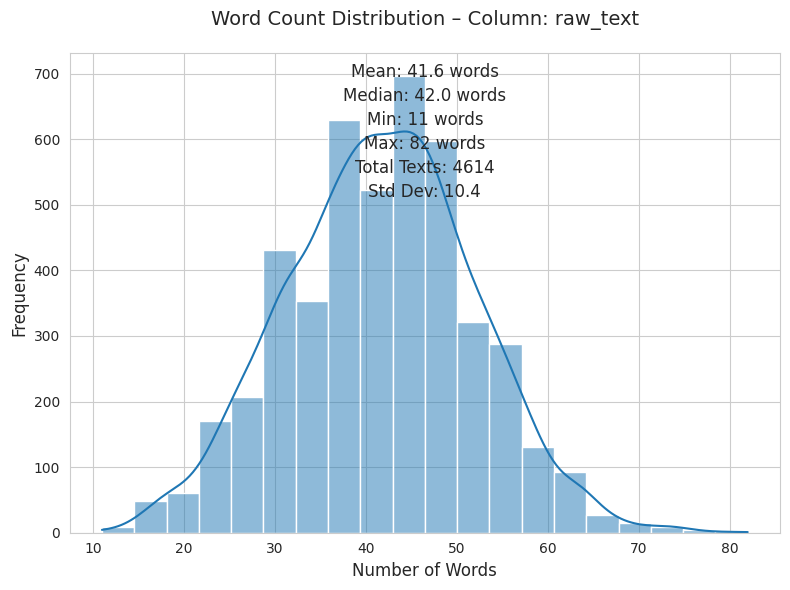

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_word_count_distribution(df, column: str, figsize=(8, 6)):
    plt.figure(figsize=figsize)
    sns.set_style("whitegrid")

    # Compute word counts
    word_counts = df[column].astype(str).str.split().apply(len)
    stats = word_counts.describe()

    # Plot histogram with density line
    sns.histplot(word_counts, bins=20, kde=True)
    plt.title(f"Word Count Distribution – Column: {column}", fontsize=14, pad=20)
    plt.xlabel("Number of Words", fontsize=12)
    plt.ylabel("Frequency", fontsize=12)

    # Overlay statistical summaries
    plt.text(0.5, 0.95, f"Mean: {stats['mean']:.1f} words",
             transform=plt.gca().transAxes, ha='center', fontsize=12)
    plt.text(0.5, 0.9, f"Median: {stats['50%']:.1f} words",
             transform=plt.gca().transAxes, ha='center', fontsize=12)
    plt.text(0.5, 0.85, f"Min: {stats['min']:.0f} words",
             transform=plt.gca().transAxes, ha='center', fontsize=12)
    plt.text(0.5, 0.8, f"Max: {stats['max']:.0f} words",
             transform=plt.gca().transAxes, ha='center', fontsize=12)
    plt.text(0.5, 0.75, f"Total Texts: {stats['count']:.0f}",
             transform=plt.gca().transAxes, ha='center', fontsize=12)
    plt.text(0.5, 0.7, f"Std Dev: {stats['std']:.1f}",
             transform=plt.gca().transAxes, ha='center', fontsize=12)

    plt.tight_layout()
    plt.show()


plot_word_count_distribution(df, column="raw_text")



In [8]:
from collections import Counter
import plotly.graph_objects as go

def plot_histogram_word(df, column: str, n_most_common=30, suffix=""):
    # Flatten all words in the column into a list
    words = [
        word
        for text in df[column].dropna().astype(str)
        for word in text.split()
    ]

    total_words = len(words)
    unique_tokens = len(set(words))
    word_counts = Counter(words)
    top_words = dict(word_counts.most_common(n_most_common))

    # Plotting
    fig = go.Figure([
        go.Bar(
            x=list(top_words.keys()),
            y=list(top_words.values()),
            text=list(top_words.values()),
            textposition="auto",
        )
    ])

    fig.update_layout(
        title_text=(
            f"Top {n_most_common} Most Frequent Words {suffix}<br>"
            f"Total Words: {total_words} • Unique Tokens: {unique_tokens}"
        ),
        title_x=0.5,
        xaxis_title="Words",
        yaxis_title="Frequency",
        xaxis_tickangle=-45,
    )

    fig.show()
plot_histogram_word(df, column="raw_text", n_most_common=40, suffix="(with stopwords)")


Unique colors combinations:
['W' 'U' 'B' 'R' 'G']


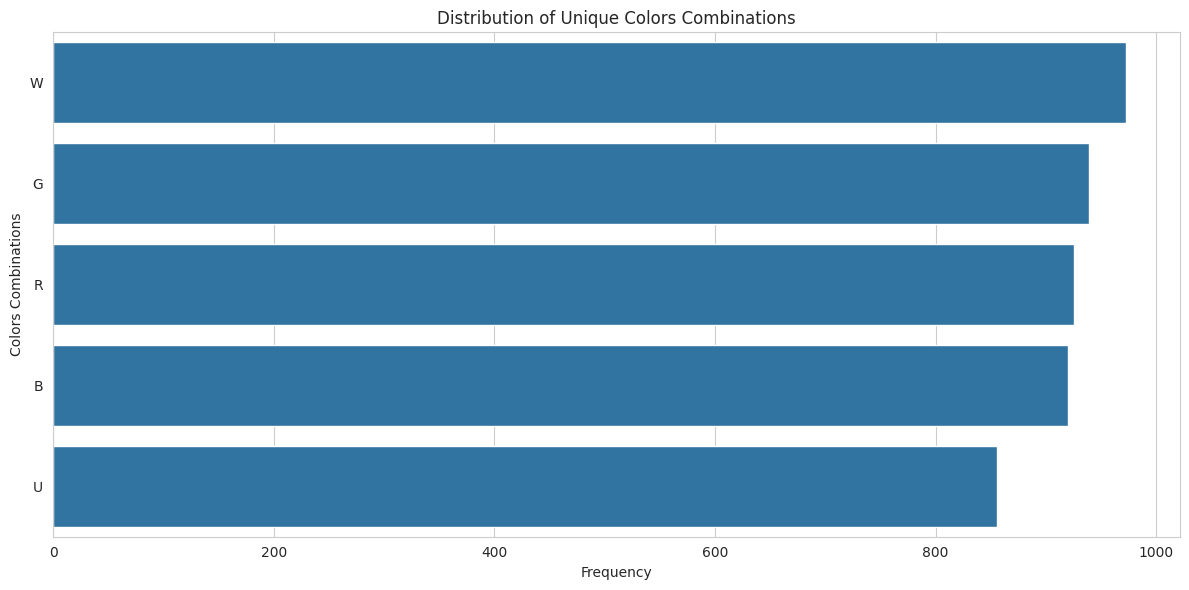

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_colors_combinations_distribution(df, target_column):
    # Convert arrays to sorted strings for consistent representation
    combinations_str = df[target_column].apply(lambda x: ", ".join(sorted(x)) if isinstance(x, (list, tuple)) else str(x))

    unique_combinations = combinations_str.unique()
    print(f"Unique {target_column} combinations:")
    print(unique_combinations)

    plt.figure(figsize=(12, 6))
    sns.countplot(y=combinations_str, order=combinations_str.value_counts().index)
    plt.title(f"Distribution of Unique {target_column.capitalize()} Combinations")
    plt.xlabel("Frequency")
    plt.ylabel(f"{target_column.capitalize()} Combinations")
    plt.tight_layout()
    plt.show()

plot_colors_combinations_distribution(df, "colors")



In [10]:
df.to_csv('dataset.csv', index=False)
df[['colors','raw_text']]

,colors,raw_text
0,W,Eleito da Ancestral - Iniciativa (Esta criatur...
1,W,Anjo de Misericórdia - Voar (Esta criatura só ...
2,W,Bênção Angelical - A criatura alvo recebe +3/+...
3,W,Coro Angelical - Toda vez que uma criatura ent...
4,W,"Barreira Angelical - Defensor, voar (Esta cria..."
...,...,...
4609,G,Petróglifos de Muraganda - Criaturas sem habil...
4610,G,Banquete Fosforescente - Revele qualquer númer...
4611,G,Trasgo Jogapraga - Mágicas que têm como alvo T...
4612,G,Arqueiro de Espinoflora - Alcance (Esta criatu...


# FINE TUNING DO BERT USANDO O DATASET DE CARTAS

\
# Separa e define os datasets




In [19]:
from sklearn.model_selection import train_test_split
import datasets

# 1. Separar conjunto de teste final
df_rest, df_test = train_test_split(
     df[['raw_text', 'colors']], test_size=0.1, random_state=271828, stratify=df['colors']
)

# 2. Separar treino e validação do restante
df_train, df_valid = train_test_split(
    df_rest, test_size=0.2, random_state=271828, stratify=df_rest['colors']
)

# 3. Remover rótulos para MLM
df_train_for_mlm = df_train.drop(columns=["colors"])
df_valid_for_mlm = df_valid.drop(columns=["colors"])

# 4. Conversões para datasets Hugging Face
dataset_train_for_mlm = datasets.Dataset.from_pandas(df_train_for_mlm)
dataset_valid_for_mlm = datasets.Dataset.from_pandas(df_valid_for_mlm)
dataset_train_for_classification = datasets.Dataset.from_pandas(df_train)
dataset_valid_for_classification = datasets.Dataset.from_pandas(df_valid)
dataset_test = datasets.Dataset.from_pandas(df_test)




In [21]:
print(dataset_train_for_mlm)
print(dataset_valid_for_mlm)
print(dataset_train_for_classification)
print(dataset_valid_for_classification)
print(dataset_test)


Dataset({
    features: ['raw_text', '__index_level_0__'],
    num_rows: 3321
})
Dataset({
    features: ['raw_text', '__index_level_0__'],
    num_rows: 831
})
Dataset({
    features: ['raw_text', 'colors', '__index_level_0__'],
    num_rows: 3321
})
Dataset({
    features: ['raw_text', 'colors', '__index_level_0__'],
    num_rows: 831
})
Dataset({
    features: ['raw_text', 'colors', '__index_level_0__'],
    num_rows: 462
})


In [23]:
from transformers import AutoTokenizer

# 5. Inicializar tokenizer do BERT (Português cased)
tokenizer = AutoTokenizer.from_pretrained(
    "neuralmind/bert-base-portuguese-cased",
    use_fast=True
)

# 6. Função de tokenização
def preprocess_function(examples):
    return tokenizer(examples["raw_text"], truncation=True, padding="max_length", max_length=512)

# 7. Tokenizar todos os datasets
dataset_train_tokenized_mlm = dataset_train_for_mlm.map(preprocess_function, batched=True)
dataset_valid_tokenized_mlm = dataset_valid_for_mlm.map(preprocess_function, batched=True)
dataset_train_tokenized_classification = dataset_train_for_classification.map(preprocess_function, batched=True)
dataset_valid_tokenized_classification = dataset_valid_for_classification.map(preprocess_function, batched=True)
dataset_test_tokenized = dataset_test.map(preprocess_function, batched=True)


Map:   0%|          | 0/3321 [00:00<?, ? examples/s]

Map:   0%|          | 0/831 [00:00<?, ? examples/s]

Map:   0%|          | 0/3321 [00:00<?, ? examples/s]

Map:   0%|          | 0/831 [00:00<?, ? examples/s]

Map:   0%|          | 0/3321 [00:00<?, ? examples/s]

Map:   0%|          | 0/831 [00:00<?, ? examples/s]

Map:   0%|          | 0/462 [00:00<?, ? examples/s]

In [24]:
from random import randint

# Função auxiliar para imprimir uma amostra aleatória de um dataset
def show_sample(dataset, name):
    idx = randint(0, len(dataset) - 1)
    print(f"\n{name} [index {idx}]:")
    for k, v in dataset[idx].items():
        print(f"  {k}: {v}")

# Exibir amostras de cada dataset tokenizado
show_sample(dataset_train_tokenized_mlm, "Train - MLM")
show_sample(dataset_valid_tokenized_mlm, "Validation - MLM")
show_sample(dataset_train_tokenized_classification, "Train - Classification")
show_sample(dataset_valid_tokenized_classification, "Validation - Classification")
show_sample(dataset_test_tokenized, "Test - Classification")



Train - MLM [index 2454]:
  raw_text: Vingadora Sagrada - A criatura equipada tem golpe duplo. Toda vez que a criatura equipada causa dano de combate, você pode colocar um card de Aura de sua mão no campo de batalha anexado a ela. Equipar {2}{M} A luz divina forjada em aço.
  __index_level_0__: 944
  input_ids: [101, 15140, 2017, 9065, 671, 118, 177, 15799, 3094, 285, 376, 5532, 10053, 119, 6957, 576, 179, 123, 15799, 3094, 285, 2318, 14029, 125, 3076, 117, 3983, 706, 7201, 222, 7200, 125, 14320, 22278, 125, 327, 4014, 202, 2244, 125, 2971, 6870, 201, 123, 740, 119, 6717, 1038, 22282, 195, 245, 197, 195, 213, 197, 177, 3377, 14380, 344, 8140, 173, 9828, 119, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

# Tokenizacao para fine tuning

# Fine Tunning


In [35]:
from transformers import DataCollatorWithPadding
import gc
import torch
from pathlib import Path
from transformers import AutoTokenizer

# Create a data collator that dynamically pads the inputs to the maximum length in the batch
# This ensures that all inputs in a batch have the same length, which is required for efficient processing
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

# free up memory
model_pretrained = None
trainer_pretrained = None
gc.collect()
torch.cuda.empty_cache()

# Define the path where the language model will be saved
path_to_save_lm = Path("./outputs/nlp_deep_learning/bert_masked_lm")

# Create the directory (and any necessary parent directories) if it doesn't already exist
path_to_save_lm.mkdir(parents=True, exist_ok=True)

# Load the pre-trained BERT tokenizer for Portuguese without truncation
# This tokenizer will not truncate the input text, which means it will keep the full length of the text
# The 'use_fast=True' parameter enables the fast version of the tokenizer for better performance
tokenizer_no_truncation = AutoTokenizer.from_pretrained("neuralmind/bert-base-portuguese-cased", use_fast=True, truncation=False)

In [37]:
# Função de tokenização sem truncamento
def tokenize_function_no_truncation(examples):
    """
    Tokenizes the input text in the given examples using the tokenizer object.

    Args:
    - examples: A dictionary containing the input text to be tokenized.

    Returns:
    - A dictionary containing the tokenized input text.
    """
    result = tokenizer(examples["raw_text"])
    if tokenizer.is_fast:
        result["word_ids"] = [result.word_ids(i) for i in range(len(result["input_ids"]))]
    return result

# Tokeniza o dataset de treino (para MLM)
dataset_train_tokenized_mlm = dataset_train_for_mlm.map(
    tokenize_function_no_truncation,
    batched=True,
    remove_columns=["raw_text"]
)

# Tokeniza o dataset de validação (para MLM)
dataset_valid_tokenized_mlm = dataset_valid_for_mlm.map(
    tokenize_function_no_truncation,
    batched=True,
    remove_columns=["raw_text"]
)

dataset_train_tokenized_mlm


Map:   0%|          | 0/3321 [00:00<?, ? examples/s]

Map:   0%|          | 0/831 [00:00<?, ? examples/s]

Dataset({
    features: ['__index_level_0__', 'input_ids', 'token_type_ids', 'attention_mask', 'word_ids'],
    num_rows: 3321
})

In [41]:
import itertools

# Define o tamanho dos blocos de tokens para treino de linguagem
chunk_size = 512

# Função para agrupar sequências de tokens em blocos contínuos de tamanho fixo
def group_texts(examples):
    """
    Agrupa listas de tokens em blocos contínuos de tamanho fixo (chunk_size).
    Requisito para treino de masked language modeling (MLM).
    """
    # Concatena todos os exemplos (se forem listas de listas)
    concatenated_examples = {
        k: list(itertools.chain.from_iterable(examples[k]))
        if isinstance(examples[k][0], list) else examples[k]
        for k in examples
    }

    # Calcula o comprimento total ajustado ao chunk_size
    total_length = (len(concatenated_examples["input_ids"]) // chunk_size) * chunk_size

    # Agrupa os tokens em blocos de chunk_size
    result = {
        k: [t[i : i + chunk_size] for i in range(0, total_length, chunk_size)]
        for k, t in concatenated_examples.items()
    }

    # Atribui os labels para treino (no MLM, os labels são os próprios input_ids)
    result["labels"] = result["input_ids"].copy()

    return result

# Aplica a função de agrupamento ao dataset de treino
dataset_train_tokenized_mlm = dataset_train_tokenized_mlm.map(
    group_texts,
    batched=True,
)

# Aplica a função de agrupamento ao dataset de validação
dataset_valid_tokenized_mlm = dataset_valid_tokenized_mlm.map(
    group_texts,
    batched=True,
)


Map:   0%|          | 0/3321 [00:00<?, ? examples/s]

Map:   0%|          | 0/831 [00:00<?, ? examples/s]

In [42]:
from random import randint

# Seleciona um índice aleatório
idx = randint(0, len(dataset_train_tokenized_mlm) - 1)

# Exibe o exemplo correspondente
sample = dataset_train_tokenized_mlm[idx]

print(f"Exemplo {idx}:\n")
for key, value in sample.items():
    print(f"{key}: {value[:20]}{' ...' if len(value) > 20 else ''} (len={len(value)})")


Exemplo 379:

__index_level_0__: [] (len=0)
input_ids: [195, 200, 197, 131, 2627, 22287, 731, 1657, 22279, 4624, 2142, 17168, 183, 548, 146, 774, 171, 6354, 119, 113] ... (len=512)
token_type_ids: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0] ... (len=512)
attention_mask: [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1] ... (len=512)
word_ids: [2, 3, 4, 5, 6, 6, 6, 6, 6, 7, 8, 8, 8, 9, 10, 11, 12, 13, 14, 15] ... (len=512)
labels: [195, 200, 197, 131, 2627, 22287, 731, 1657, 22279, 4624, 2142, 17168, 183, 548, 146, 774, 171, 6354, 119, 113] ... (len=512)


# execucao do fine tuning


In [49]:
from transformers import DataCollatorForLanguageModeling, AutoModelForMaskedLM, TrainingArguments

# 1. Collator específico para MLM (aplica masking dinâmico nos tokens com 15% de probabilidade)
data_collator_mlm = DataCollatorForLanguageModeling(
    tokenizer=tokenizer,
    mlm=True,
    mlm_probability=0.15
)

# 2. Nome do modelo base (checkpoint do BERT em português)
model_checkpoint = "neuralmind/bert-base-portuguese-cased"

# 3. Carrega o modelo BERT pré-treinado para Masked Language Modeling
model_mlm = AutoModelForMaskedLM.from_pretrained(model_checkpoint)

# 4. Definição do batch size e extração do nome do modelo
batch_size = 16
model_name = model_checkpoint.split("/")[-1]

# 5. Configuração dos argumentos de treinamento
training_args_mlm = TrainingArguments(
    output_dir=path_to_save_lm / f"{model_name}-finetuned-mlm",  # Output directory for the trained model
    overwrite_output_dir=True,  # Overwrite the output directory if it already exists
    learning_rate=5e-5,  # Learning rate for the optimizer
    weight_decay=0.01,  # Weight decay for regularization
    per_device_train_batch_size=batch_size,  # Batch size for training. May need to be lowered for free GPUs
    per_device_eval_batch_size=batch_size,  # Batch size for evaluation. May need to be lowered for free GPUs
    fp16=True,  # Use bf16 precision. May need to be changed to fp16 for free GPUs
    num_train_epochs=20,  # Number of training epochs
    save_total_limit=1,  # Limit the total amount of checkpoints and delete the older ones
    eval_strategy="epoch",  # Evaluate the model after each epoch
    logging_strategy="steps",  # Log the training progress after each step
    save_strategy="epoch",  # Save the model after each epoch
    eval_steps=1,  # Evaluate the model after every 1 epoch
    save_steps=1,  # Save the model after every 1 epoch
    logging_steps=10,  # Log the training progress after every 1 step
    load_best_model_at_end=True,  # Load the best model at the end of training
    metric_for_best_model="eval_loss",  # Use the evaluation loss to determine the best model
    greater_is_better=False,  # Lower evaluation loss is better
    gradient_accumulation_steps=2,  # Number of steps to accumulate gradients before updating the model parameters
    seed=271828,  # Random seed for reproducibility
    report_to="none"  # Evita tentativa de log em sistemas externos como WandB
)

Some weights of the model checkpoint at neuralmind/bert-base-portuguese-cased were not used when initializing BertForMaskedLM: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [50]:
from transformers import Trainer

# Inicializa o Trainer para o treinamento de linguagem (MLM)
trainer_mlm = Trainer(
    model=model_mlm,
    args=training_args_mlm,
    train_dataset=dataset_train_tokenized_mlm,
    eval_dataset=dataset_valid_tokenized_mlm,
    data_collator=data_collator_mlm
)


In [51]:
# DEMORA!
trainer_mlm.train()

Epoch,Training Loss,Validation Loss
1,6.002200,1.983348
2,1.945400,1.564533
3,1.641700,1.453198
4,1.447900,1.399200
5,1.339800,1.324993
6,1.341700,1.312119
7,1.237400,1.247642
8,1.298000,1.219327
9,1.157800,1.247013
10,1.130000,1.227034


There were missing keys in the checkpoint model loaded: ['cls.predictions.decoder.weight', 'cls.predictions.decoder.bias'].


TrainOutput(global_step=280, training_loss=1.3919521127428327, metrics={'train_runtime': 860.1298, 'train_samples_per_second': 9.975, 'train_steps_per_second': 0.326, 'total_flos': 2258278105374720.0, 'train_loss': 1.3919521127428327, 'epoch': 20.0})

In [53]:
# Salvar o modelo fine-tuned no diretório definido
trainer_mlm.save_model(path_to_save_lm / "bert-base-finetuned-mlm")

# Salvar o tokenizer usado no processamento dos dados
tokenizer.save_pretrained(path_to_save_lm / "bert-base-finetuned-mlm")


('outputs/nlp_deep_learning/bert_masked_lm/bert-base-finetuned-mlm/tokenizer_config.json',
 'outputs/nlp_deep_learning/bert_masked_lm/bert-base-finetuned-mlm/special_tokens_map.json',
 'outputs/nlp_deep_learning/bert_masked_lm/bert-base-finetuned-mlm/vocab.txt',
 'outputs/nlp_deep_learning/bert_masked_lm/bert-base-finetuned-mlm/added_tokens.json',
 'outputs/nlp_deep_learning/bert_masked_lm/bert-base-finetuned-mlm/tokenizer.json')

# Classifier Fine Tuning


In [55]:
import gc
import torch
from transformers import AutoConfig, AutoTokenizer, BertForSequenceClassification

# free up memory
model_pretrained = None
trainer_pretrained = None
model_mlm = None
trainer_mlm = None
tokenizer = None

gc.collect()
torch.cuda.empty_cache()

color_to_id = {"R": 0, "B": 1, "U": 2, "W": 3, "G": 4}

def map_labels(example):
    example["labels"] = color_to_id[example["colors"]]
    return example

dataset_train_tokenized_classification = dataset_train_tokenized_classification.map(map_labels)
dataset_valid_tokenized_classification = dataset_valid_tokenized_classification.map(map_labels)

Map:   0%|          | 0/3321 [00:00<?, ? examples/s]

Map:   0%|          | 0/831 [00:00<?, ? examples/s]

In [56]:


# Load configuration from the fine-tuned masked language model directory
config = AutoConfig.from_pretrained("./outputs/nlp_deep_learning/bert_masked_lm/bert-base-finetuned-mlm")

# Set the number of classes for MTG color classification
config.num_labels = 5  # R, B, U, W, G

# Initialize model for sequence classification
model_ft = BertForSequenceClassification.from_pretrained(
    "./outputs/nlp_deep_learning/bert_masked_lm/bert-base-finetuned-mlm",
    config=config,
)

# Load the corresponding tokenizer
tokenizer = AutoTokenizer.from_pretrained(
    "./outputs/nlp_deep_learning/bert_masked_lm/bert-base-finetuned-mlm",
    use_fast=True,
)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at ./outputs/nlp_deep_learning/bert_masked_lm/bert-base-finetuned-mlm and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [57]:
import numpy as np
import evaluate

accuracy = evaluate.load("accuracy")


# Define a function to compute evaluation metrics
def compute_metrics(eval_pred):
    # Unpack the predictions and labels from the evaluation tuple
    predictions, labels = eval_pred

    # Convert the prediction probabilities to predicted class indices
    predictions = np.argmax(predictions, axis=1)

    # Compute and return the accuracy metric using the predicted and true labels
    return accuracy.compute(predictions=predictions, references=labels)

In [59]:
from transformers import Trainer, TrainingArguments

# Define the training arguments for the fine-tuned model
training_args_ft = TrainingArguments(
    output_dir=path_to_save_lm / f"{model_name}-ft_model",  # Output directory for the trained model
    learning_rate=2e-5,  # Learning rate for the optimizer
    per_device_train_batch_size=32,  # Batch size for training. May need to be lowered for free GPUs
    per_device_eval_batch_size=256,  # Batch size for evaluation. May need to be lowered for free GPUs
    num_train_epochs=5,  # Number of training epochs
    weight_decay=0.01,  # Weight decay for regularization
    # bf16=True,  # Use bf16 precision. May need to be changed to fp16 for free GPUs
    eval_strategy="epoch",  # Evaluate the model after each epoch
    logging_strategy="steps",  # Log the training progress after each step
    save_strategy="epoch",  # Save the model after each epoch
    eval_steps=1,  # Evaluate the model after every 1 epoch
    save_steps=1,  # Save the model after every 1 epoch
    logging_steps=10,  # Log the training progress after every 1 step
    load_best_model_at_end=True,  # Load the best model at the end of training
    seed=271828,  # Random seed for reproducibility
    report_to="none"
)

# Initialize the Trainer for the fine-tuned model
trainer_ft = Trainer(
    model=model_ft,  # The fine-tuned model to train
    args=training_args_ft,  # The training arguments defined above
    train_dataset=dataset_train_tokenized_classification,  # The tokenized training dataset
    eval_dataset=dataset_valid_tokenized_classification,  # The tokenized evaluation dataset
    data_collator=data_collator,  # The data collator for dynamic padding and batching
    compute_metrics=compute_metrics,  # The function to compute the evaluation metrics
)


In [60]:
# Train the fine-tuned model DEMORA!!
trainer_ft.train()

Epoch,Training Loss,Validation Loss,Accuracy
1,1.102000,1.039351,0.637786
2,0.752700,0.815680,0.722022
3,0.513700,0.741873,0.758123
4,0.372300,0.737060,0.765343
5,0.293400,0.726487,0.779783


TrainOutput(global_step=520, training_loss=0.6770367975418384, metrics={'train_runtime': 617.0123, 'train_samples_per_second': 26.912, 'train_steps_per_second': 0.843, 'total_flos': 4369076755614720.0, 'train_loss': 0.6770367975418384, 'epoch': 5.0})

In [61]:
# Evaluate the fine-tuned model on the evaluation dataset
# This will return a dictionary containing the evaluation metrics
results_ft = trainer_ft.evaluate()

# Display the evaluation results
# The results will include metrics such as loss, accuracy, etc.
results_ft

{'eval_loss': 0.7264872193336487,
 'eval_accuracy': 0.779783393501805,
 'eval_runtime': 6.3787,
 'eval_samples_per_second': 130.278,
 'eval_steps_per_second': 0.627,
 'epoch': 5.0}

In [62]:
# Mapeia os rótulos do dataset de teste para inteiros (caso ainda não esteja feito)
dataset_test = dataset_test.map(map_labels)

# Tokeniza o dataset de teste
dataset_test_tokenized = dataset_test.map(
    lambda examples: tokenizer(examples["raw_text"], truncation=True, padding=True, max_length=512),
    batched=True
)

# Avaliação no conjunto de teste
results_test = trainer_ft.evaluate(eval_dataset=dataset_test_tokenized)

# Exibir resultados da avaliação
results_test


Map:   0%|          | 0/462 [00:00<?, ? examples/s]

Map:   0%|          | 0/462 [00:00<?, ? examples/s]

{'eval_loss': 0.6094299554824829,
 'eval_accuracy': 0.803030303030303,
 'eval_runtime': 0.9856,
 'eval_samples_per_second': 468.759,
 'eval_steps_per_second': 2.029,
 'epoch': 5.0}

In [63]:
import evaluate
import numpy as np

# Carrega os avaliadores
accuracy_metric = evaluate.load("accuracy")
precision_metric = evaluate.load("precision")
recall_metric = evaluate.load("recall")
f1_metric = evaluate.load("f1")

# Função de cálculo das métricas
def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)

    return {
        "accuracy": accuracy_metric.compute(predictions=predictions, references=labels)["accuracy"],
        "precision": precision_metric.compute(predictions=predictions, references=labels, average="weighted")["precision"],
        "recall": recall_metric.compute(predictions=predictions, references=labels, average="weighted")["recall"],
        "f1": f1_metric.compute(predictions=predictions, references=labels, average="weighted")["f1"]
    }


In [64]:
trainer_ft = Trainer(
    model=model_ft,
    args=training_args_ft,
    train_dataset=dataset_train_tokenized_classification,
    eval_dataset=dataset_valid_tokenized_classification,
    data_collator=data_collator,
    compute_metrics=compute_metrics
)

results_test = trainer_ft.evaluate(eval_dataset=dataset_test_tokenized)
results_test


{'eval_loss': 0.6094299554824829,
 'eval_model_preparation_time': 0.003,
 'eval_accuracy': 0.803030303030303,
 'eval_precision': 0.8040786416059827,
 'eval_recall': 0.803030303030303,
 'eval_f1': 0.8017826008379143,
 'eval_runtime': 0.9385,
 'eval_samples_per_second': 492.301,
 'eval_steps_per_second': 2.131}

# Usando o modelo bert sem fine tuning - WIP
#  --------------------------------------------------------------------------------## ---------------------------------------------------------------------------------



In [ ]:
from transformers import AutoConfig, AutoTokenizer, BertForSequenceClassification
import torch

# Nome do modelo pré-treinado em português
base_model = "neuralmind/bert-base-portuguese-cased"

# Carrega a configuração e define o número de classes
config = AutoConfig.from_pretrained(base_model)
config.num_labels = 5  # R, B, U, W, G

# Inicializa o modelo de classificação baseado no BERT em português
model_ft = BertForSequenceClassification.from_pretrained(
    base_model,
    config=config
)

# Carrega o tokenizer correspondente
tokenizer = AutoTokenizer.from_pretrained(
    base_model,
    use_fast=True
)


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at neuralmind/bert-base-portuguese-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
from transformers import Trainer, TrainingArguments

# Define the training arguments for the fine-tuned model
training_args_ft = TrainingArguments(
    output_dir=path_to_save_lm / f"{model_name}-ft_model",  # Output directory for the trained model
    learning_rate=2e-5,  # Learning rate for the optimizer
    per_device_train_batch_size=32,  # Batch size for training. May need to be lowered for free GPUs
    per_device_eval_batch_size=256,  # Batch size for evaluation. May need to be lowered for free GPUs
    num_train_epochs=5,  # Number of training epochs
    weight_decay=0.01,  # Weight decay for regularization
    # bf16=True,  # Use bf16 precision. May need to be changed to fp16 for free GPUs
    eval_strategy="epoch",  # Evaluate the model after each epoch
    logging_strategy="steps",  # Log the training progress after each step
    save_strategy="epoch",  # Save the model after each epoch
    eval_steps=1,  # Evaluate the model after every 1 epoch
    save_steps=1,  # Save the model after every 1 epoch
    logging_steps=10,  # Log the training progress after every 1 step
    load_best_model_at_end=True,  # Load the best model at the end of training
    seed=271828,  # Random seed for reproducibility
    report_to="none"
)

# Initialize the Trainer for the fine-tuned model
trainer_ft = Trainer(
    model=model_ft,  # The fine-tuned model to train
    args=training_args_ft,  # The training arguments defined above
    train_dataset=dataset_train_tokenized_classification,  # The tokenized training dataset
    eval_dataset=dataset_valid_tokenized_classification,  # The tokenized evaluation dataset
    processing_class=tokenizer,  # The tokenizer used to preprocess the input text
    data_collator=data_collator,  # The data collator for dynamic padding and batching
    compute_metrics=compute_metrics,  # The function to compute the evaluation metrics
)

# Train the fine-tuned model
trainer_ft.train()

Epoch,Training Loss,Validation Loss,Accuracy
1,1.590300,1.584025,0.266522
2,1.556100,1.519957,0.396533
3,1.427200,1.437979,0.445287
4,1.327600,1.379512,0.494041
5,1.196500,1.361300,0.499458


TrainOutput(global_step=95, training_loss=1.416166114807129, metrics={'train_runtime': 362.9539, 'train_samples_per_second': 8.266, 'train_steps_per_second': 0.262, 'total_flos': 177296404590000.0, 'train_loss': 1.416166114807129, 'epoch': 5.0})

In [ ]:
# Evaluate the fine-tuned model on the evaluation dataset
# This will return a dictionary containing the evaluation metrics
results_ft = trainer_ft.evaluate()

# Display the evaluation results
# The results will include metrics such as loss, accuracy, etc.
results_ft

{'eval_loss': 1.2660893201828003,
 'eval_accuracy': 0.542795232936078,
 'eval_runtime': 7.7904,
 'eval_samples_per_second': 118.479,
 'eval_steps_per_second': 0.513,
 'epoch': 5.0}

In [ ]:
from pprint import pprint
pprint(results_ft)


{'epoch': 5.0,
 'eval_accuracy': 0.542795232936078,
 'eval_loss': 1.2660893201828003,
 'eval_runtime': 7.7904,
 'eval_samples_per_second': 118.479,
 'eval_steps_per_second': 0.513}


In [ ]:
predictions_output = trainer_ft.predict(dataset_valid_tokenized_classification)


In [ ]:
import numpy as np

logits = predictions_output.predictions
predicted_classes = np.argmax(logits, axis=1)
true_labels = predictions_output.label_ids


In [ ]:
from sklearn.metrics import classification_report

# Define o mapeamento inverso, se necessário
id_to_color = {0: "R", 1: "B", 2: "U", 3: "W", 4: "G"}

# Substitui os índices pelos nomes das cores (opcional)
predicted_labels = [id_to_color[i] for i in predicted_classes]
true_labels_named = [id_to_color[i] for i in true_labels]

print(classification_report(true_labels_named, predicted_labels, digits=4))


              precision    recall  f1-score   support

           B     0.6350    0.4728    0.5421       184
           G     0.4601    0.5213    0.4888       188
           R     0.4095    0.6973    0.5160       185
           U     0.5952    0.4386    0.5051       171
           W     0.5455    0.3692    0.4404       195

    accuracy                         0.4995       923
   macro avg     0.5291    0.4998    0.4985       923
weighted avg     0.5279    0.4995    0.4976       923



In [ ]:
from sklearn.metrics import classification_report, matthews_corrcoef
import numpy as np

# Gera as previsões no conjunto de validação
predictions_output = trainer_ft.predict(dataset_valid_tokenized_classification)

# Extrai os logits e os rótulos reais
logits = predictions_output.predictions
true_labels = predictions_output.label_ids
predicted_classes = np.argmax(logits, axis=1)

# Mapeamento opcional: índices → rótulos (se quiser usar letras)
id_to_color = {0: "R", 1: "B", 2: "U", 3: "W", 4: "G"}
true_labels_named = [id_to_color[i] for i in true_labels]
predicted_labels_named = [id_to_color[i] for i in predicted_classes]

# Exibe o classification report por classe
print("🔎 Classification Report (por classe):")
print(classification_report(true_labels_named, predicted_labels_named, digits=4))

# Calcula o MCC
mcc = matthews_corrcoef(true_labels, predicted_classes)
print(f"\n🧠 Matthews Correlation Coefficient (MCC): {mcc:.4f}")


🔎 Classification Report (por classe):
              precision    recall  f1-score   support

           B     0.6350    0.4728    0.5421       184
           G     0.4601    0.5213    0.4888       188
           R     0.4095    0.6973    0.5160       185
           U     0.5952    0.4386    0.5051       171
           W     0.5455    0.3692    0.4404       195

    accuracy                         0.4995       923
   macro avg     0.5291    0.4998    0.4985       923
weighted avg     0.5279    0.4995    0.4976       923


🧠 Matthews Correlation Coefficient (MCC): 0.3812
